# CMS Dimuon spectrum analyis in Julia

Analysis running time: 25.6 s on my Laptop (i7-8550U CPU @ 1.80GHz, 4 cores, 8 GByte RAM, with SSD). The Python version took 4h54mn. RDataframe with Cling or Numba takes takes less time, but still long than Julia.


# Analysis of the di-muon spectrum using data from the CMS detector

This analysis takes data from the CMS experiment recorded in 2012 during Run B and C and extracts the di-muon spectrum. The di-muon spectrum is computed from the data by calculating the invariant mass of muon pairs with opposite charge. In the resulting plot, you are able to rediscover particle resonances in a wide energy range from the [eta meson](https://en.wikipedia.org/wiki/Eta_meson) at about 548 MeV up to the [Z boson](https://en.wikipedia.org/wiki/W_and_Z_bosons) at about 91 GeV.

The analysis code opens an interactive plot, which allows to zoom and navigate in the spectrum. Note that the bump at 30 GeV is not a resonance but an effect of the data taking due to the used trigger. The technical description of the dataset can be found in the respective record linked below.

The result of this analysis can be compared with [an official result of the CMS collaboration using data taken in 2010](https://cds.cern.ch/record/1456510), see the plot below:

![](http://cds.cern.ch/record/1456510/files/pictures_samples_dimuonSpectrum_40pb-1_mod-combined.png)

# Dataset description

The dataset consists of the following columns.

| Column name | Data type | Description |
|-------------|-----------|-------------|
| `nMuon` | `unsigned int` | Number of muons in this event |
| `Muon_pt` | `float[nMuon]` | Transverse momentum of the muons (stored as an array of size `nMuon`) |
| `Muon_eta` | `float[nMuon]` | Pseudorapidity of the muons |
| `Muon_phi` | `float[nMuon]` | Azimuth of the muons |
| `Muon_mass` | `float[nMuon]` | Mass of the muons |
| `Muon_charge` | `int[nMuon]` | Charge of the muons (either 1 or -1) |

## Some utilities we will need

Define four-momentum and histogram tools

In [1]:
using NBInclude
@nbinclude("JuliaUtils.ipynb")

## Download the data file

To run this example, we need to download the CMS data file from [here](https://zenodo.org/record/5091596/files/Muons.bin?download=1) and save it with the name ``Muons.bin`` in the dimu directory containing this notebook. The file is 3.3 GByte big.

In [2]:
run(`wget --progress dot:giga -O Muons.bin "https://zenodo.org/record/5091596/files/Muons.bin?download=1"`)

## Function to read the data

In [3]:
function read(func, fname, maxevents = -1)
    ievt = fill(zero(Int32), (1))
    nMuon = fill(zero(Int32), (1))
    arr_size = 100
    Muon = fill((; pt=zero(Float32), eta=zero(Float32), phi=zero(Float32), mass=zero(Float32), charge=zero(Int32)), (arr_size))
    evtcnt = 0
    open(fname) do io
        while !eof(io) && (maxevents < 0 || evtcnt < maxevents)
            n = read!(io, ievt)
            if ievt[1] != evtcnt 
                error("Error while reading the file. $(ievt[1]) != $evtcnt")
            end
            read!(io, nMuon)
            if nMuon[1] > length(Muon)
                resize!(Muon, nMuon[1])
            end
            Muon_ = @view(Muon[1:nMuon[1]])
            read!(io, Muon_)
            func(Muon_)
            evtcnt = evtcnt + 1
        end
    end
end
;

## The dimuon analysis

We loop on the events. The input file contains the muon collection of the event 
that we retrieve with the `read` method. Below the function that peforms this loop.

In [4]:
function ana()
    bins = 30_000 # Number of bins in the histogram
    low = 0.25 # Lower edge of the histogram
    up = 300.0 # Upper edge of the histogram
    h = H1{Float64}(Axis(bins, low, up))
    nPairs = 0
    read("Muons.bin", -1) do muons
        length(muons) == 2 || return
        muons[1].charge != muons[2].charge || return
        dimuon_mass = m(ptetaphim(muons[1].pt, muons[1].eta, muons[1].phi, muons[1].mass)
                    + ptetaphim(muons[2].pt, muons[2].eta, muons[2].phi, muons[2].mass))
        hfill!(h, dimuon_mass)
    end
    return h
end
;

 
### Notice the `do` construct in the above 💡

The first parameter of the `read` method is a function and was omitted in the code above. The `do` operator constructs a lambda function that is passed as first parameter of the function.

In Julia,

```julia
map(v) do x
    2x
end```

is equivalent to

```julia
map(x->2x, v)
```
that will be implemented in Python as:

```python
map(lambda: x->2x, v)
````

and in modern c++

```c++
map([](auto x){return 2*x;}, v)
```

It provides a neat construct by moving the lambda function definition out of the parenthesis. It's used in place of the ''with'' Python constructs:  ``with open("file") as io`` ⇒  ``open("file") do io``

Let's time the analysis that took 4h 54min in Python on the same laptop I'm using now. The file contains 61.5 million events.

In [5]:
@time h=ana();

 23.193814 seconds (326.23 M allocations: 6.696 GiB, 2.71% gc time, 0.02% compilation time)


# Let's make the plot

Julia has many plotting packages. The Gadfly package provides a common front-end to the different packages allowing easy switch from one package to another and promoting interface standardisation.

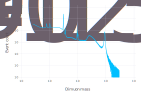

In [6]:
import Gadfly as gf
p = gf.plot(x=xedges(h), y=vcat(h.sumw[2:end-1], [h.sumw[end-1]]), gf.Geom.step, 
        gf.Scale.x_log10(minvalue=0.25, maxvalue=300.), gf.Scale.y_log10,
        gf.Guide.xlabel("Dimuon mass"), gf.Guide.ylabel("Event count"))

## Dataframe

⚡ Julia support also DataFrame and an equivalent of Dask, so the analysis could also have been done with DataFrames. ⚡

[back to the presentation](01-Julia-dream-PyHEP2021.ipynb)